Minimum in x=18.9 with f(x)=-15.1
The value of (x,y) should be [3.62857088] [0.00526034]
The value of (x,y) should be [15.70506178] [-8.26031493]
The value of (x,y) should be [13.95401954] [-1.93351336]
The value of (x,y) should be [16.73705638] [-11.62356416]
The value of (x,y) should be [18.09328808] [-14.56034891]
The value of (x,y) should be [18.94853508] [-15.12495587]


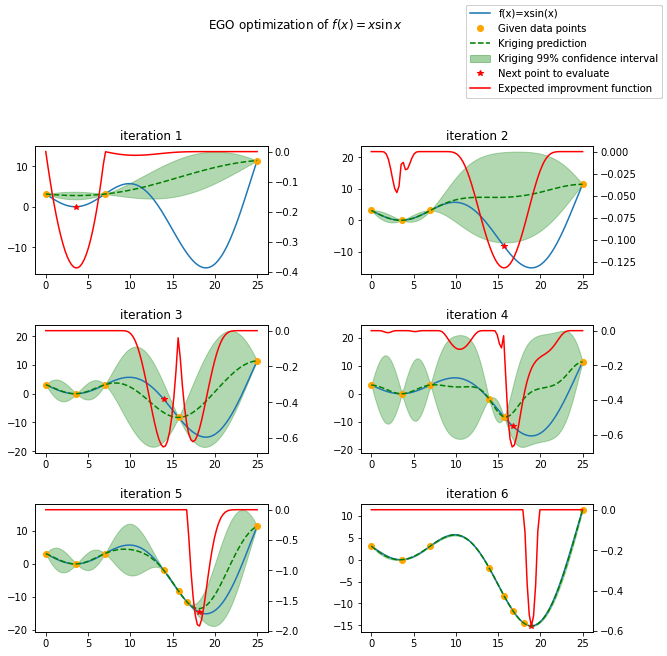

In [12]:
import numpy as np
from smt.applications import EGO
from smt.surrogate_models import KRG
from smt.utils.design_space import DesignSpace
import matplotlib.pyplot as plt
import numpy as np

def function_test_1d(x):
    # function xsinx
    
    x = np.reshape(x, (-1,))
    y = np.zeros(x.shape)
    y = (x - 3.5) * np.sin((x - 3.5) / (np.pi))
    return y.reshape((-1, 1))

n_iter = 6
xlimits = np.array([[0.0, 25.0]])
design_space = DesignSpace(xlimits)
xdoe = np.atleast_2d([0, 7, 25]).T
n_doe = xdoe.size

criterion = "EI"  #'EI' or 'SBO' or 'LCB'

# use EI to create ego, xdoe is for initializing the EGO function.
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=KRG(design_space=design_space, print_global=False),
)

# How do they get this.
x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=function_test_1d)

print("Minimum in x={:.1f} with f(x)={:.1f}".format(float(x_opt), float(y_opt)))

x_plot = np.atleast_2d(np.linspace(0, 25, 100)).T
y_plot = function_test_1d(x_plot)

fig = plt.figure(figsize=[10, 10])
for i in range(n_iter):
    k = n_doe + i
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]

    # Through current sampling data points, we approxiamte the current GP model.
    ego.gpr.set_training_values(x_data_k, y_data_k)
    ego.gpr.train()
    
    # Then we use the GP model to predict values based on current x values.
    y_gp_plot = ego.gpr.predict_values(x_plot)
    y_gp_plot_var = ego.gpr.predict_variances(x_plot)

    y_ei_plot = -ego.EI(x_plot)

    ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
    ax1 = ax.twinx()
    (ei,) = ax1.plot(x_plot, y_ei_plot, color="red")

    (true_fun,) = ax.plot(x_plot, y_plot)
    (data,) = ax.plot(
        x_data_k, y_data_k, linestyle="", marker="o", color="orange"
    )
    if i < n_iter:
        (opt,) = ax.plot(
            x_data[k], y_data[k], linestyle="", marker="*", color="r"
        )
        print('The value of (x,y) should be '+str(x_data[k])+' '+str(y_data[k]))
    (gp,) = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")
    sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
    sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
    un_gp = ax.fill_between(
        x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    lines = [true_fun, data, gp, un_gp, opt, ei]
    fig.suptitle("EGO optimization of $f(x) = x \sin{x}$")
    fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
    ax.set_title("iteration {}".format(i + 1))
    fig.legend(
        lines,
        [
            "f(x)=xsin(x)",
            "Given data points",
            "Kriging prediction",
            "Kriging 99% confidence interval",
            "Next point to evaluate",
            "Expected improvment function",
        ],
    )
plt.show()



In [3]:
num_dim = 5
n_iter = 50


In [25]:
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging

results_pth = './results'
if not os.path.exists(results_pth):
    os.mkdir(results_pth)

class Logger(object):
    def __init__(self, path):
        self.logger = logging.getLogger()
        self.path = path
        self.setup_file_logger()
        print ('Logging to file: ', self.path)
        
    def setup_file_logger(self):
        hdlr = logging.FileHandler(self.path, 'w+')
        self.logger.addHandler(hdlr) 
        self.logger.setLevel(logging.INFO)

    def log(self, message):
        print (message)
        self.logger.info(message)

class MLP(nn.Module):
    def __init__(self, in_plane, inter_plane, out_class):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
                        # nn.Flatten(),
                        nn.Linear(in_plane, inter_plane),
                        nn.ReLU(),
                        nn.Linear(inter_plane, inter_plane),
                        nn.ReLU(),
                        nn.Linear(inter_plane, inter_plane),
                        nn.ReLU()
        )
        self.classifier = nn.Linear(inter_plane, out_class)
        
    def forward(self, x):
        out = self.mlp(x)
        out = out.view(out.size(0), -1)
        logits = self.classifier(out)
        out = F.softmax(logits, dim=1)
        return out, logits

loss = nn.MSELoss()

In [26]:
import numpy as np
from smt.applications import EGO
from smt.surrogate_models import KRG
from smt.utils.design_space import DesignSpace
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.stats import qmc
import time

in_plane = 100
out_class = 10

input_range = [0, 1] 
target_softmax = np.random.dirichlet(np.ones(out_class), size=1)
xlimits = np.array([[input_range[0], input_range[1]] for i in range(in_plane)]) 
    
# LHS settings
number_samples = 5 * in_plane

sampler = qmc.LatinHypercube(d=in_plane)
samples = sampler.random(n=number_samples)
samples = qmc.scale(samples, l_bounds=[0]*in_plane, u_bounds=[1]*in_plane)


In [27]:
def function_test_100d(X):

    in_plane = 100
    inter_plane = 300
    out_class = 10
    
    X = torch.from_numpy(X).float()
    Y_list = []
    broadcasted_target_softmax = torch.from_numpy(np.tile(target_softmax, (500, 1))).float()
    X = X.cuda()
    broadcasted_target_softmax = broadcasted_target_softmax.cuda()

    model = MLP(in_plane=in_plane, inter_plane=inter_plane, out_class=out_class)
    model = model.cuda()
    out, logits = model(X)
    
    for i in range(len(out)):
        output_loss = loss(out[i], broadcasted_target_softmax[i])
        Y_list.append(output_loss.cpu().detach().numpy())
    Y_array = np.array(Y_list).reshape(len(Y_list), -1)
    return Y_array

def EGO_start():
    n_iter = 100
    design_space = DesignSpace(xlimits)
    logger = Logger(os.path.join(results_pth, 'log-ego.log'))
    
    logger.log('EGO_start')
    logger.log('We randomly sample {} samples with {} dimensions'.format(number_samples, in_plane))
    logger.log('The target softmax value is '+str(target_softmax))
    
    criterion = 'EI'

    ego = EGO(
        n_iter=n_iter,
        criterion=criterion,
        xdoe=samples,
        surrogate=KRG(design_space=design_space, print_global=False)
    )
    
    time_start = time.time()
    x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=function_test_100d)
    time_end = time.time()

    logger.log('The process time is '+str(time_end - time_start))
    logger.log('\n')    
    logger.log('Optimized input X is '+str(x_opt))
    logger.log('\n')
    logger.log('Optimized output y is '+str(y_opt))
    logger.log('\n')
    logger.log('The shape of input data is '+str(x_data.shape))
    logger.log('\n')
    logger.log('The length of input data is '+str(len(y_data)))
    logger.log('\n')
    logger.log('The input data refer to '+str(x_data))
    logger.log('\n')
    logger.log('The output data refer to '+str(y_data))

EGO_start()


# def function_test_5d(X):
#     a1, a2, a3, a4, a5, b = [-4.31, -1.12, -0.43, -2.72, 1.81, -4.50]
#     y_list = []
#     for i in range(X.shape[0]):
#         y_list.append(a1 * (X[i][0] - 1.04)**2 + a2 * np.sin((X[i][1]-3.5)/(np.pi)) + 
#                  a3 * np.exp(X[i][2]) + a4 * np.cos((X[i][3] - 3.5) / (np.pi)) + a5 * (X[i][4] - 2.86)**4 + b)
#     y_array = np.array(y_list).reshape(len(y_list),-1)
#     return y_array   
    
# xlimits = np.array([[0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0]])
# design_space = DesignSpace(xlimits)

# xdoe = np.array([[1.2, 0.4, 0.9, 3.8, 2.4], [2.8, 6.9, 5.2, 4.3, 5.5], [3.2, 2.4, 3.0, 6.5, 8.2]])
# ndoe = xdoe.shape[0]

# criterion = "EI"  #'EI' or 'SBO' or 'LCB'

# # use EI to create ego, xdoe is for initializing the EGO function.
# ego = EGO(
#     n_iter=n_iter,
#     criterion=criterion,
#     xdoe=xdoe,
#     surrogate=KRG(design_space=design_space, print_global=False),
# )

# vectors = [np.linspace(0, 10.0, 100) for _ in range(num_dim)]
# x_plot = np.column_stack(vectors)

# x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=function_test_5d)
# print(x_opt)
# print(y_opt)
# csv_save(x_data, y_data, 'function_test_5d'+'_iter='+str(n_iter))
# print("Minimum is x f(x)={:.1f}".format(float(y_opt)))

# for i in range(n_iter):
#     k = ndoe + i
#     x_data_k = x_data[0:k]
#     y_data_k = y_data[0:k]

#     # Through current sampling data points, we approxiamte the current GP model.
#     ego.gpr.set_training_values(x_data_k, y_data_k)
#     ego.gpr.train()
    
#     # Then we use the GP model to predict values based on current x values.
#     y_gp_plot = ego.gpr.predict_values(x_plot)
#     y_gp_plot_var = ego.gpr.predict_variances(x_plot)
    
#     y_ei_plot = -ego.EI(x_plot)
    


Logging to file:  ./results/log-ego.log
EGO_start
We randomly sample 500 samples with 100 dimensions
The target softmax value is [[0.03437477 0.21854774 0.11268377 0.04767861 0.03545808 0.08668627
  0.11146111 0.30038191 0.0426301  0.01009765]]
